# Modeling

In [9]:
import pickle
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors


In [10]:
tweet_tokenizer = TweetTokenizer(preserve_case=True, strip_handles=True, reduce_len=True)
lemmatizer = WordNetLemmatizer()

def tokenize_lemmatize_tweet(tweet):
    ''' 
    Tokenize then Lemmatize the given tweet 
    '''
    #remove links
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    #tokenize
    tokens = tweet_tokenizer.tokenize(tweet)
    #lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

def calc_and_display_performance_metric(the_estimator, Xtest, ytest, Xtrain, ytrain, classifier_predictions, cm_title, cm_normalize=None):
    '''
    Calcuate and display peformance metrics for a classifier
    '''
    # Metrics - on how well the classifer performed on test data AND getting metrics on training data to check for model overfitting.
    train_predictions = the_estimator.predict(Xtrain)
    show_peformance_metrics(ytrain, train_predictions, Xtest, ytest, classifier_predictions)
    # Confusion Matrix
    plot_pretty_cf(the_estimator, Xtest, ytest, cm_normalize, cm_title)

def show_peformance_metrics(y_train, y_train_pred, X_test, y_test, y_pred):
    ''' 
    Print out peformance metrics
    '''
    train_acc_core = accuracy_score(y_train, y_train_pred)
    test_acc_score = accuracy_score(y_test, y_pred)
    train_wf1_score = f1_score(y_train, y_train_pred, average='weighted')
    test_wf1_score = f1_score(y_test, y_pred, average='weighted')
    print('--------------------------------------------------------------------------')
    print('Training Accuracy:{:.4}\t\t Testing Accuracy: {:.4}'.format(train_acc_core, test_acc_score))
    print('Training Weighted F1:{:.4}\t\t Testing Weighted F1: {:.4}'.format(train_wf1_score, test_wf1_score))
    print('--------------------------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    print('--------------------------------------------------------------------------')

def plot_pretty_cf(the_estimator, Xtest, ytest, cm_normalize, title):
    ''' Plot a pretty confusion matrix '''
    fig, ax = plt.subplots(figsize=(6, 6))
    plot_confusion_matrix(the_estimator, Xtest, ytest, cmap='Blues', normalize=cm_normalize, ax=ax)
    ax.set_title(title, size='large')
    ax.set_xlabel('Predicted Label', size='medium')
    ax.set_ylabel('True Label', size='medium')
    plt.show()

In [11]:
us_only_tweets = pd.read_csv('../data/vetted_usa_tweets.csv')

In [12]:
us_only_tweets['sentiment'].value_counts()
# We have class imbalance here with MANY more positive tweets

positive    22618
neutral      4708
negative     3273
Name: sentiment, dtype: int64

## Modeling Steps:

* Create TRAIN and TEST data sets

* Create a Pipeline to use GridSearchCV to find best hyperparameters for LinearSVC, and fit the best LinearSVC model
    * Apply light text processing and vectorize TRAIN data using TF-IDF 
    * Use 'vanilla' classification model
    * Define parameter grid for consideration by GridSearchCV
    * Use GridSearchCV to peform hyperparameter tuning to fit/train the best model

* Create predictions for TEST set

* Examine performance metrics: Weighted F1 Scores
    * Compare the performance metrics for TRAIN and TEST  (If model does __much__ better on TRAIN than on TEST set, then we’re likely overfitting)

### Create TRAIN and TEST data sets

In [13]:
X = us_only_tweets['content']
y = us_only_tweets['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Text Processing

Vectorize the Tweets using TF-IDF
* Using TF-IDF to vectorize tweets.
    * TD-IDF focuss on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.
* Using a custom function as tokenzier (tokenize_lemmatize_tweet)
    * URLs will be removed using a regex
    * TweetTokenier will tokenize the Tweets - usernames/handles will be stripped, case will be retained, and repeated characters in words will be reduced (ex: waaaay to way)
    *Wordnet Lemmatizer on the resulting tokens
* Removing english stopwords
    * __Not__ removing/stripping punctuation as it may be useful for sentiment classifification

In [14]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_lemmatize_tweet,
                             stop_words=stopwords.words('english'),
                             decode_error='ignore')

### Honing in on the 'best' text classifer

In the model_playground.ipynb, I experimented with the following:
* RandomForestClassifier
* SGDClassifier
* LinearSVC

The LinearSVC was the most promising, so I'll focus on creating the 'best' classification model using LinearSVC.


--------------------------------------------------------------------------
Training Accuracy:0.9951		 Testing Accuracy: 0.924
Training Weighted F1:0.9952		 Testing Weighted F1: 0.923
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.83      0.77      0.80       953
     neutral       0.87      0.83      0.85      1420
    positive       0.95      0.97      0.96      6807

    accuracy                           0.92      9180
   macro avg       0.88      0.85      0.87      9180
weighted avg       0.92      0.92      0.92      9180

--------------------------------------------------------------------------


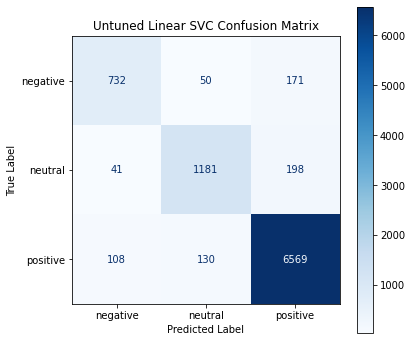

In [15]:
# Linear SVC with no hyperparameter tuning
not_tuned_lsvc_clf = Pipeline([('tfidf', vectorizer),
                               ('clf', LinearSVC(class_weight='balanced', max_iter=2000))
                               ])

not_tuned_lsvc_clf.fit(X_train, y_train)
predictions = not_tuned_lsvc_clf.predict(X_test)

calc_and_display_performance_metric(the_estimator=not_tuned_lsvc_clf, 
                                    Xtest=X_test, 
                                    ytest=y_test,
                                    Xtrain=X_train,
                                    ytrain=y_train,
                                    classifier_predictions=predictions,
                                    cm_title='Untuned Linear SVC Confusion Matrix')

### Hyperparameter tuning
Tune using GridSearchCV to find the best Hyperparameters
* Using weighted F1 as the performance metric
* using setting class_weight to be 'balanced' as we have class imbalance with __MANY__ more positive tweets than negative or neutral.

In [16]:
# Linear SVC was very promising!  Let's perform hyperparameter tuning with GridSearchCV!

lsvc_pipeline = Pipeline([ ('tfidf', vectorizer), ('estimator', LinearSVC()) ])

p_grid = {'estimator__penalty': ['l1', 'l2'],
          'estimator__class_weight': ['balanced'],
          'estimator__random_state': [42],
          'estimator__loss': ['hinge', 'squared_hinge'],
          'estimator__dual': [True, False],
          'estimator__C' : [.1, 1, 10],
          'estimator__max_iter' : [1000, 2000]
          }

#using 10 fold cross validation instead of default of 5
grid_lsvc = GridSearchCV(estimator=lsvc_pipeline,
                          param_grid=p_grid,
                          scoring='f1_weighted',
                          verbose=1,
                          n_jobs=-1,
                          cv=10)

grid_lsvc.fit(X_train, y_train)
best_lsvc_clf = grid_lsvc.best_estimator_
print(grid_lsvc.best_score_)
print(grid_lsvc.best_params_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 22.2min finished
0.9386883242927674
{'estimator__C': 1, 'estimator__class_weight': 'balanced', 'estimator__dual': False, 'estimator__loss': 'squared_hinge', 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'estimator__random_state': 42}


--------------------------------------------------------------------------
Training Accuracy:0.9827		 Testing Accuracy: 0.9423
Training Weighted F1:0.9828		 Testing Weighted F1: 0.9423
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    negative       0.86      0.80      0.83       953
     neutral       0.86      0.95      0.90      1420
    positive       0.97      0.96      0.97      6807

    accuracy                           0.94      9180
   macro avg       0.90      0.90      0.90      9180
weighted avg       0.94      0.94      0.94      9180

--------------------------------------------------------------------------


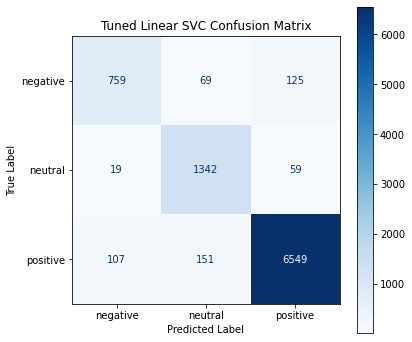

In [17]:
predictions = best_lsvc_clf.predict(X_test)

calc_and_display_performance_metric(the_estimator=best_lsvc_clf, 
                                    Xtest=X_test, 
                                    ytest=y_test,
                                    Xtrain=X_train,
                                    ytrain=y_train,
                                    classifier_predictions=predictions,
                                    cm_title='Tuned Linear SVC Confusion Matrix')

### Model performance evaluation

* The tuned LinearSVC model has a weighted F1 score of __0.94__ which is very good performance
* Let's examine the F1 score (and total number of tweets) for each class:
    * Positive class has F1 score of 0.97 (no surprise as this the majority class) 
    * Neutral class has F1 score of 0.90
    * Negative class has F1 score of 0.83
* The lowest F1 score is for the least represented class, Negative. However, the overall Weighted F1 score of 0.94 is very acceptable.
* The model does not appear to suffer from overfitting.  The Train score is higher than the Test score, but not __substaintially__ higher.
    * Train F1 Score: __0.98__
    * Test F1 Score: __0.94__

#### Save the Trained Classifer
Now that we've used Grid Search CV to determine the best hyperparameters for the LinearSVC model and have trained it. Pickle the trained model for use with new data.

In [18]:
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime('%d_%b_%Y_%H_%M')
timestamped_model_filename = 'fitted_lsvc_model_' + timestampStr + '.pickle'

with open(timestamped_model_filename, 'wb') as modelFile:
    pickle.dump(best_lsvc_clf, modelFile)

#### Use the Classifier on new data - the data comes from Tweets that are NOT in the Training or Test set.

In [25]:
#Load pre-trained model - no need to retrain it again
with open(timestamped_model_filename, 'rb') as modelFile:
    stored_model = pickle.load(modelFile)


In [26]:
new_data = {'content': 
    ['@jac___13 Sorry Jackie! I’ve kept our kids fully remote, even opting out of the hybrid model. I just can’t trust other outside of my bubble right now. At least you guys in K-12 are in the earlier phases to get vaccinated. My wife in higher-Ed is not. I truly feel for educators right now.', 
    'Parents, Grandparents, and Guardians! Explore Pre-K and K-12 options, tour schools and chat LIVE with school representatives during our Virtual School Fair.\nhttps://t.co/ogqDR4m52K', 
    'Screw the open schools COVID movement for damaging the term open schools.\n\nAn Open School is a K-12 self-directed democratic school.\nJCOS in Denver Colorado is the last Open School in USA\n\nHere\'s an EP we released w/ a former student &amp; teacher.\n\nhttps://t.co/3hJ2sGwMLD https://t.co/jbIfpO80UP', 
    'How does creating a federally supported K-12 to postsecondary education pathway help America recover from the COVID-19 pandemic? \n\nRead the new @amprog report to learn more: https://t.co/mCTe84WFtO #CAPEducation', 
    'Parents! 🗣️ @DaytonLive365 is offering a free “virtual field trip” for local K-12 students from Feb. 1 to March 14. Register here for access to stream Grammy-nominated duo, Black Violin: https://t.co/XR29EKm2TT https://t.co/mCb6W2vUZp',
    'There are two parts to the bill; the second would require districts to offer a 5 day per week, in-person option for all students, but only *after* the completion of vaccination phase 1b.  K-12 teachers and staff are included in SDMAC\'s 1b plan.'
    ] }

new_data_df = pd.DataFrame.from_dict(new_data)

stored_model.predict(new_data_df['content'])

array(['negative', 'positive', 'negative', 'positive', 'positive',
       'neutral'], dtype=object)

### Conclusion: Good performance on this final model!

The predictions for the new data seem reasonable. All 3 sentiment classes were detected. Even the negative sentiment, which is the least represented sentiment class in the Training/Test data.

## Recommendation:
* For other Data Scientists seeking to expand upon this work:  The collected data has a class imbalance issue with 73.9% of the data labeled as Positive. Make sure any hyperparameter tuning uses the 'balanced' class_weight for LinearSVC or any other classification algorithm you may choose to experiment with. If class_weight 'balanced' is not an option, consider using RandomOverSampling to address the imbalance.

### Future Work:
* Create a dashboard/app to classify tweets from the live Twitter stream 
    * Allow user to set for entire United States, selected US region(s) or selected US state(s)
* Continue to collect Tweets over a longer timespan and update model